In [1]:
cache_dir = "D://hubface_cache"

In [ ]:
from tqdm import tqdm

from transformers import ( RobertaTokenizer)
from datasets import Dataset
from transformers import RobertaTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import multiprocessing
import torch

import evaluate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Data preparation

In [3]:
pd.set_option('max_colwidth', 400)
df = pd.read_csv('../datasets/marked_sard_vdisc_train.csv')
df.head()
df_0 = df[df['Label'] == 0].sample(frac=0.12, random_state=42)
df_1 = df[df['Label'] == 1]
df = pd.concat([df_0, df_1])
df = df.sample(frac=0.3, random_state=42)

df.head()

,code,CWE-119,CWE-120,CWE-469,CWE-476,CWE-OTHERS,Label,DataType
651418,"reset_eterm_image(image_t *image_tPointerMarker, unsigned long unsignedMarker)\n{\n ASSERT(image_tPointerMarker != NULL);\n\n D_PIXMAP((""reset_image(%8p, 0x%08x)\n"", image_tPointerMarker, unsignedMarker));\n\n if ((unsignedMarker & RESET_NORM) && image_tPointerMarker->norm) {\n reset_simage(image_tPointerMarker->norm, unsignedMarker);\n }\n if ((unsignedMarker & RESET_SE...",False,False,False,True,False,1,VDISC
450729,"toggled_default_inmd(GtkCellRendererToggle *GtkCellRendererTogglePointerMarker, gchar *gcharPointerMarker, gpointer gpointerMarker)\n{\n GtkTreeModel *GtkTreeModelPointerMarker = GTK_TREE_MODEL (gpointerMarker);\n clear_col_default_inmd(GtkTreeModelPointerMarker);\n GtkTreeIter iter;\n GtkTreePath *GtkTreePathPointerMarker = gtk_tree_path_new_from_string (gcharPointerMarker);\n\n gtk_tre...",True,True,False,False,False,1,VDISC
149600,"sys_cleanup(void)\n{\n\n if (if_is_up) {\n if_is_up = 0;\n sifdown(0);\n }\n\n if (have_default_route)\n cifdefaultroute(0, 0, 0);\n\n if (has_proxy_arp)\n cifproxyarp(0, proxy_arp_addr);\n}\n\n",False,False,False,False,False,0,VDISC
39517,"evh1(struct mg_connection *structPointerMarker, enum mg_event enumMarker) {\n char *charPointerMarker = (char *) structPointerMarker->connection_param;\n int intMarker = MG_FALSE;\n\n switch (enumMarker) {\n case MG_CONNECT:\n mg_printf(structPointerMarker, ""GET %s HTTP/1.0\r\n\r\n"",\n charPointerMarker[0] == '1' ? ""/cb1"" : ""/non_exist"");\n intMarker = MG_TRUE;...",False,False,False,False,False,0,VDISC
1030602,"\n \n \n #include ""IncludeMarker""\n \n typedef struct _CWE190_Integer_Overflow__unsigned_int_rand_add_67_structType\n {\n unsigned int intMarker;\n } CWE190_Integer_Overflow__unsigned_int_rand_add_67_structType;\n \n #ifndef OMITBAD\n \n \n void VoidFunctionMarker(CWE190_Integer_Overflow__unsigned_int_rand_add_67_structType myStruct);\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n void Void...",False,False,False,False,True,1,SARD


C:\Users\bowsw\AppData\Local\Temp\ipykernel_5904\895471566.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vuln_counts.index, y=vuln_counts.values, palette='viridis')


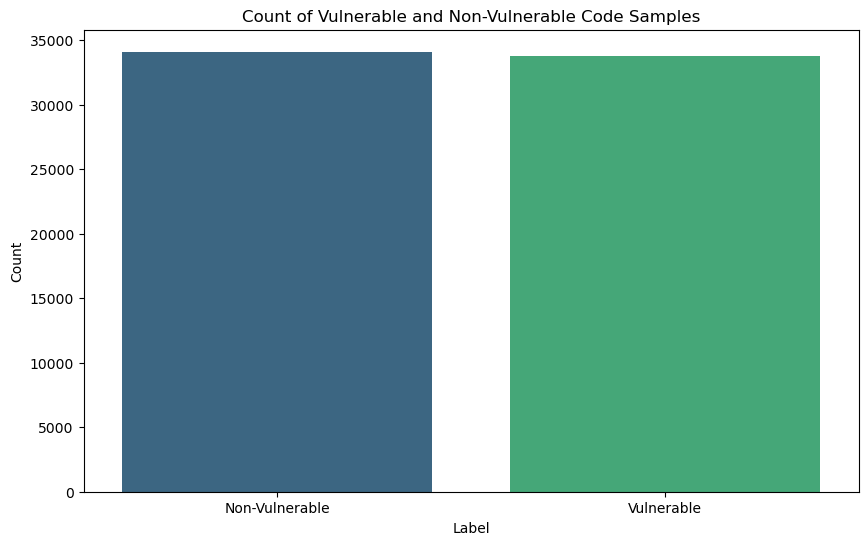

C:\Users\bowsw\AppData\Local\Temp\ipykernel_5904\895471566.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cwe_counts.index, y=cwe_counts.values, palette='viridis')


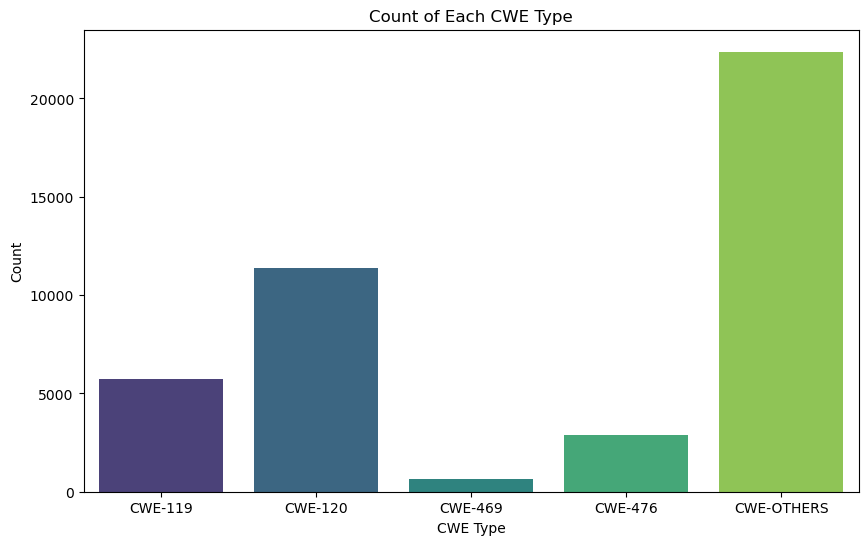

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# Count the number of vulnerable and non-vulnerable code samples
vuln_counts = df['Label'].value_counts()

# Create a bar plot for vulnerable and non-vulnerable code samples
plt.figure(figsize=(10, 6))
sns.barplot(x=vuln_counts.index, y=vuln_counts.values, palette='viridis')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Vulnerable and Non-Vulnerable Code Samples')
plt.xticks(ticks=[0, 1], labels=['Non-Vulnerable', 'Vulnerable'])
plt.show()

# Count the occurrences of each CWE type
cwe_counts = df[['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-OTHERS']].sum()

# Create a bar plot for CWE types
plt.figure(figsize=(10, 6))
sns.barplot(x=cwe_counts.index, y=cwe_counts.values, palette='viridis')
plt.xlabel('CWE Type')
plt.ylabel('Count')
plt.title('Count of Each CWE Type')
plt.show()


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
dataset = {}
dataset['text'] = list(df_train['code'])
dataset['label'] = list(df_train['Label'])
ds = Dataset.from_dict(dataset)
ds = ds.train_test_split(test_size=0.1)

In [7]:
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base-mlm', cache_dir="D://hubface_cache")

In [8]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/48885 [00:00<?, ? examples/s]

Map:   0%|          | 0/5432 [00:00<?, ? examples/s]

In [9]:
tokenized_dataset.save_to_disk("../datasets/tokenized_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/48885 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5432 [00:00<?, ? examples/s]

In [10]:
from datasets import load_from_disk
tokenized_dataset = load_from_disk("../datasets/tokenized_dataset")


In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base-mlm", num_labels=2, cache_dir="D://hubface_cache"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

C:\Users\bowsw\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\bowsw\AppData\Local\Temp\ipykernel_5904\565366963.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.336300,0.331003,0.863218


TrainOutput(global_step=3056, training_loss=0.36059838314955145, metrics={'train_runtime': 1253.633, 'train_samples_per_second': 38.995, 'train_steps_per_second': 2.438, 'total_flos': 1.28621839412736e+16, 'train_loss': 0.36059838314955145, 'epoch': 1.0})

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in tqdm(df_test['code'].values):
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt", truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)
        

100%|██████████| 13580/13580 [03:02<00:00, 74.35it/s]


In [16]:
from sklearn.metrics import classification_report
print(classification_report([i for i in df_test['Label'].values], preds))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86      6728
           1       0.89      0.81      0.85      6852

    accuracy                           0.85     13580
   macro avg       0.86      0.85      0.85     13580
weighted avg       0.86      0.85      0.85     13580



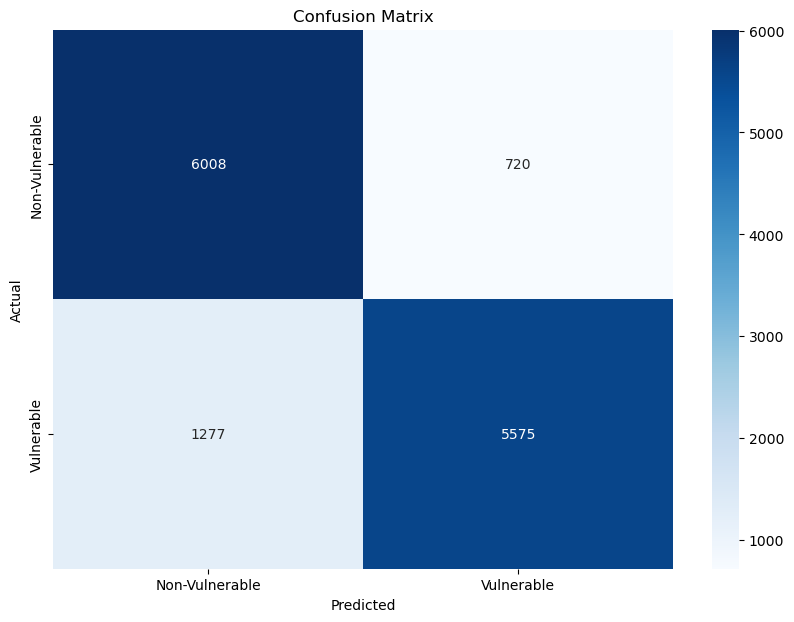

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(df_test['Label'].values, preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Vulnerable', 'Vulnerable'], yticklabels=['Non-Vulnerable', 'Vulnerable'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()